Install dependencies

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import Video
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import sys
Running_in_colab = 'google.colab' in sys.modules

display = Display(visible=0, size=(1400, 900))
display.start()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

from PartI_lib import archs as archs
from PartI_lib import performance_evaluation as eval
from PartI_lib import train_loop as tl
from PartI_lib import my_tools as mt
# !mkdir Checkpoints
import time


True
cuda:0


In [3]:
#@title Deep RL Replay Buffer

class ReplayBuffer:
    def __init__(self, size, input_shape,dev):
        self.size = size
        self.counter = 0
        self.state_buffer = torch.zeros((self.size, input_shape))
        self.action_buffer = torch.zeros(self.size, dtype=torch.int64)
        self.reward_buffer = torch.zeros(self.size)
        self.new_state_buffer = torch.zeros((self.size, input_shape))
        self.terminal_buffer = torch.zeros(self.size)
        self.state_buffer.to(dev)
        self.action_buffer.to(dev)
        self.reward_buffer.to(dev)
        self.new_state_buffer.to(dev)
        self.terminal_buffer.to(dev)
        self.dev=dev;



    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch].to(self.dev)
        action_batch = self.action_buffer[batch].to(self.dev)
        reward_batch = self.reward_buffer[batch].to(self.dev)
        new_state_batch = self.new_state_buffer[batch].to(self.dev)
        done_batch = self.terminal_buffer[batch].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch
    def last_buffer(self, batch_size):
        state_batch = self.state_buffer[-1:-batch_size].to(self.dev)
        action_batch = self.action_buffer[-1:-batch_size].to(self.dev)
        reward_batch = self.reward_buffer[-1:-batch_size].to(self.dev)
        new_state_batch = self.new_state_buffer[-1:-batch_size].to(self.dev)
        done_batch = self.terminal_buffer[-1:-batch_size].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch


Default DQN arquitecture

OpenAI Environment CartPole-v0

###    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
###    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
###    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
###    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
###    Reward:
        Reward is 1 for every step taken, including the termination step
###    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
###    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
        Episode length is greater than 200.
###     Solved Requirements:
        Considered solved when the average return is greater than or equal to 195.0 over 20 consecutive trials.

In [4]:
#@title DQN movie generation (for visual evaluation in Google Colab)

def createMovie(Network,path,Filename):
    env = gym.make("CartPole-v0")
    envX = wrappers.Monitor(env,path+'/'+Filename,force=True)

    observation = envX.reset()

    i=0
    Network.eval()

    while True:
        envX.render()
        
        state=torch.Tensor(observation).to(device)
      
        action = Network.policy(state);
             
        observation, reward, done, info = envX.step(action.item()) 
        i=i+1;     
        if done: 
          break;

    envX.close()
    env.close();
    Network.train()
    mp4list = glob.glob(path+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        if(Running_in_colab):
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
        else:
            # print("Loc Video")
            # print(mp4)
            # print("VIDEO PR")
            Video(mp4)

            # HTML("""
            #         <video alt="test" controls>
            #             <source src="test.mp4" type="video/mp4">
            #         </video>
            #     """)
    else: 
        print("Could not find video")

In [5]:
# from IPython.display import HTML

# Video("openaigym.video.19.10825.video000000.mp4")
# HTML('<iframe width="560" height="315" src="openaigym.video.19.10825.video000000.mp4" frameborder="0" allowfullscreen></iframe>')

Run the new netwwork with random policy

In [6]:
# randomnet=RandomNet(2)
# createMovie(randomnet,"random")

Initialization and Parameters:


DuelingDQN_128_1_001_2e-03_099_1e-02_097
0 of 2000
18.0 18 18.0 18.0
20.0 20 19.0 19.0
32.0 32 23.333333333333332 23.333333333333332
34.0 34 20.333333333333332 20.333333333333332
38.0 38 19.5625 19.5625
25 of 2000
41.0 41 20.2 20.307692307692307
59.0 59 23.5 21.285714285714285
80.0 80 25.1 22.186046511627907
50 of 2000
75 of 2000
100 of 2000
125 of 2000
81.0 81 25.45 23.87
90.0 90 29.15 24.57
150 of 2000
175 of 2000
200 of 2000
157.0 157 44.95 29.97
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
200.0 200 74.5 53.69
425 of 2000
200.0 200 75.2 56.05
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
200.0 200 123.65 88.36
200.0 200 130.5 99.08
575 of 2000
200.0 200 134.95 100.73
200.0 200 142.85 101.91
200.0 200 143.55 108.33
200.0 200 142.5 110.74
200.0 200 137.85 111.61
200.0 200 138.55 113.21
200.0 200 140.0 114.2
600 of 2000
200.0 200 136.85 122.49
625 of 2000
200.0 200 128.9 129.4
200.0 200 127.0 129.36
200.0 200 122.85 130.

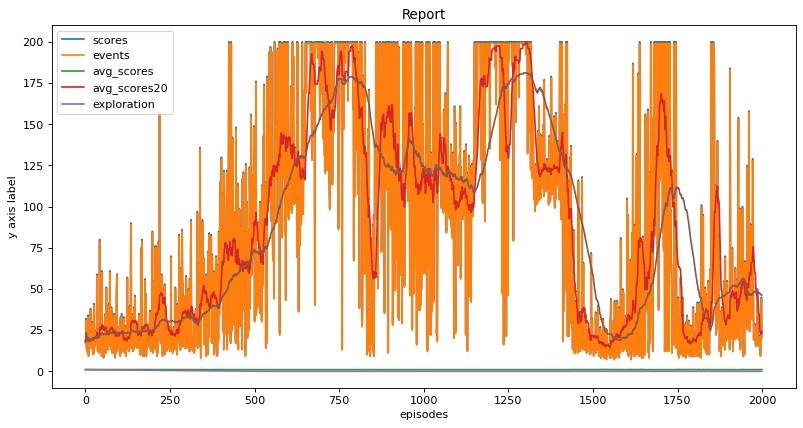

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-03_097
0 of 2000
27.0 27 27.0 27.0
37.0 37 32.0 32.0
53.0 53 32.75 32.75
65.0 65 32.714285714285715 32.714285714285715
25 of 2000
50 of 2000
70.0 70 26.65 24.491525423728813
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
103.0 103 15.15 12.31
425 of 2000
106.0 106 15.85 13.04
107.0 107 25.05 14.89
450 of 2000
107.0 107 29.6 15.71
109.0 109 34.45 16.67
109.0 109 34.6 17.64
111.0 111 44.25 19.56
113.0 113 69.3 25.35
113.0 113 83.95 28.29
115.0 115 99.35 32.29
118.0 118 104.7 33.38
118.0 118 110.15 37.32
475 of 2000
118.0 118 111.1 40.45
119.0 119 112.15 42.56
125.0 125 114.55 49.9
126.0 126 116.9 55.47
129.0 129 118.25 58.81
500 of 2000
132.0 132 123.15 75.76
142.0 142 126.45 91.07
525 of 2000
146.0 146 128.1 94.78
148.0 148 131.9 102.48
550 of 2000
150.0 150 138.5 123.85
151.0 151 138.65 124.29
159.0 159 139.9 124.

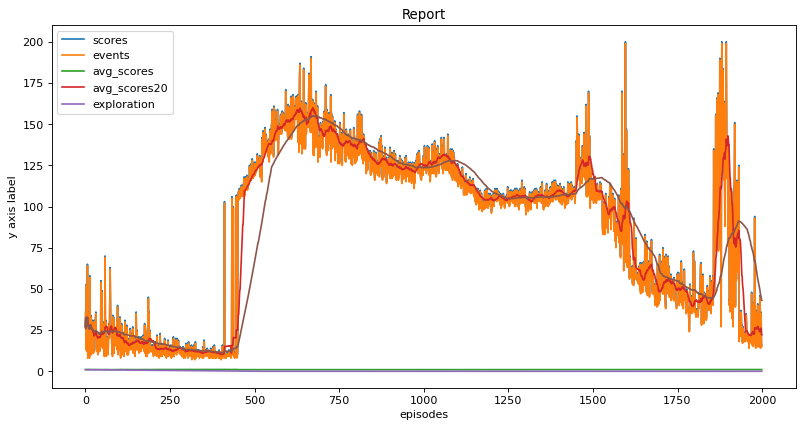

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-04_097
0 of 2000
15.0 15 15.0 15.0
36.0 36 25.5 25.5
40.0 40 17.166666666666668 17.166666666666668
25 of 2000
45.0 45 21.75 19.027027027027028
50 of 2000
50.0 50 23.25 20.50877192982456
82.0 82 25.55 21.442622950819672
91.0 91 29.65 22.634920634920636
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
147

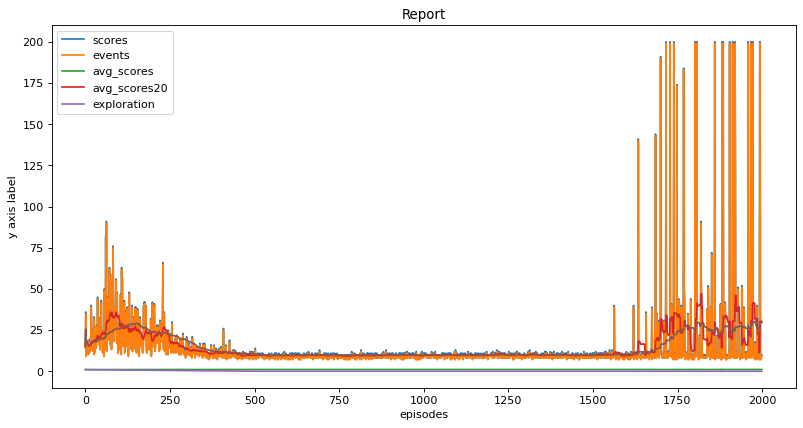

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-02_097
0 of 2000
68.0 68 68.0 68.0
25 of 2000
50 of 2000
68.0 68 21.85 22.887096774193548
75 of 2000
100 of 2000
125 of 2000
150 of 2000
91.0 91 27.3 23.61
175 of 2000
200 of 2000
225 of 2000
121.0 121 35.2 27.62
250 of 2000
275 of 2000
300 of 2000
153.0 153 53.45 38.89
325 of 2000
172.0 172 64.0 47.06
350 of 2000
375 of 2000
400 of 2000
425 of 2000
200.0 200 90.05 67.0
450 of 2000
475 of 2000
500 of 2000
525 of 2000
200.0 200 116.7 88.31
200.0 200 125.45 91.52
200.0 200 129.95 93.04
200.0 200 135.05 94.17
200.0 200 139.3 94.69
200.0 200 154.4 100.95
550 of 2000
200.0 200 161.7 104.9
200.0 200 168.05 105.91
200.0 200 169.95 107.54
200.0 200 169.95 109.18
200.0 200 165.3 114.33
200.0 200 169.2 117.42
575 of 2000
200.0 200 143.05 129.78
200.0 200 144.05 131.39
200.0 200 147.4 132.5
200.0 200 147.4 134.25
200.0 200 147.45 134.8
200.0 200 152.05 137.26
200.0 200 158.4 139.12
200.0 200 162.4 140.48
200.0 200 170.6 141.46
200.0 200 171.1

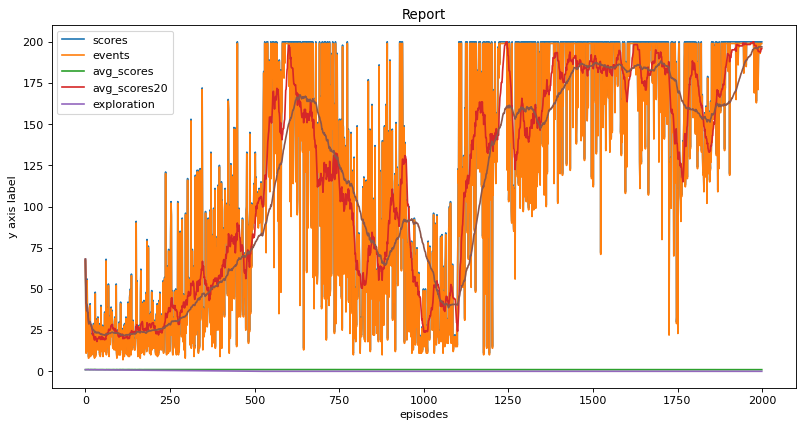

Could not find video
DuelingDQN_128_1_001_2e-03_099_1e-03_097
0 of 2000
13.0 13 13.0 13.0
24.0 24 18.5 18.5
29.0 29 20.25 20.25
31.0 31 21.25 21.25
36.0 36 22.11764705882353 22.11764705882353
25 of 2000
46.0 46 21.65 20.933333333333334
60.0 60 24.3 22.647058823529413
65.0 65 27.65 23.404255319148938
50 of 2000
73.0 73 29.5 25.957142857142856
75 of 2000
77.0 77 32.5 27.050632911392405
100 of 2000
86.0 86 34.2 29.12
125 of 2000
150 of 2000
129.0 129 34.15 34.39
130.0 130 37.25 36.0
175 of 2000
194.0 194 64.9 41.17
200 of 2000
225 of 2000
195.0 195 53.2 56.52
250 of 2000
200.0 200 102.35 71.91
200.0 200 112.6 72.44
275 of 2000
300 of 2000
325 of 2000
200.0 200 81.7 87.0
350 of 2000
200.0 200 95.5 94.91
200.0 200 113.05 100.11
200.0 200 118.85 100.44
200.0 200 128.45 100.47
375 of 2000
400 of 2000
200.0 200 110.1 99.29
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
200.0 200 95.2 100.38
200.0 200 110.15 102.8
200.0 200 124.0 105.41
200.0 200 128.25 106.65
200.0 200

KeyboardInterrupt: 

In [7]:


# Sim configuration
env = gym.make("CartPole-v0")
spec = gym.spec("CartPole-v0")



inputs=4
n_actions=2

#hyper-parameters
TotalEpisodes=2000
MaxSteps=200
FreezeCounter=25
BatchSize=128
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.002
discount_factor=0.99
SaveAtCounter=200
LearningRateDecay=0.97


# arch = "DQN"

#network DQN


buffer = ReplayBuffer(1000000, inputs,device);

# print(policy_net)
for arch in ["DuelingDQN","DQN"]:
    for n_layers in [0,5]:
        policy_net, target_net = archs.archs(arch,inputs,n_actions,discount_factor,device,n_layers)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
        file_path_ = mt.create_dir("results","N"+str(n_layers)+"_Layers")
        for LearningRate in [0.01,0.001, 0.0001]:
            optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=LearningRateDecay)
            loss = torch.nn.MSELoss()
            def trainModel():
                if buffer.counter < BatchSize:
                    return 0.0
                
                state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer.sample_buffer(BatchSize)

                q_actual = torch.gather(policy_net(state_batch),1,action_batch.reshape(-1,1))
                with torch.no_grad():
                    q_max_next = target_net(new_state_batch).max(1)[0].detach()
                q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch

                ll=loss(q_actual, q_target.unsqueeze(1))

                # Optimize the model
                optimizer.zero_grad()
                ll.backward()
                for param in policy_net.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()

                return ll.item();
            file_name = mt.set_name(arch,BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,LearningRate,LearningRateDecay)
            file_path = mt.create_dir(file_path_,file_name)
            mt.create_dir(file_path,"Checkpoints")
            print(file_name)
            bestNet, episodes, scores, events, avg_scores, avg_scores20, exploration, avg_scores100 = tl.train_loop(policy_net, target_net, env, device, TotalEpisodes, FreezeCounter, SaveAtCounter, createMovie, MaxSteps, exploration_threshold, exploration_decay, exploration_threshold_min, buffer, trainModel,file_path)

            eval.performance_evaluation(file_path,episodes, scores, events, avg_scores, avg_scores20, exploration, avg_scores100)
            eval.report(file_path,arch,BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,
                        LearningRate,LearningRateDecay,episodes, scores, events, avg_scores, avg_scores20, exploration, n_layers,avg_scores100)
            createMovie(bestNet,file_path,'bestNet')
            time.sleep(1)